Data Science 100 Project: Individual Project Planning Stage  | Owen Chen 73602740

(1) Data Description 

players.csv: This data set contains 7 variables and 196 observations.

#### Table 1. Variable Names, Types and Meaning in players.csv

| Variable     | Type      | Meaning                                                        |
|---------------|-----------|----------------------------------------------------------------|
| experience    | factor    |Minecraft Gaming Experience level (Veteran, Pro, Amateur, Regular).        |
| subscribe     | logical   | Status of player's subscription (TRUE/FALSE).             |
| hashedEmail   | character | Anonymous email addresses of players and session data.                             |
| played_hours  | double    | Total number of hours played by the individual on the server.                                  |
| name          | character |The Player's Display name                                             |
| gender        | factor    | Gender of the player                                            |
| Age           | integer   | Player's age in years.                                     |

sessions.csv: This data set contains 5 variables and 1535 observations

#### Table 2. Variable Names, Types and Meaning in sessions.csv

| Variable     | Type      | Meaning                                                        |
|---------------|-----------|----------------------------------------------------------------|
| hashedEmail   | Character    |Anonymous email addresses of players and session data.        |
| start_time          |Character |The timestamp start of a gameplay session in Milliseconds.
| end_time            |Character |The timestamp stop of a gameplay session in Milliseconds.                           |
| original_start_time |Double    |Start time in Epoch Milliseconds.                                      |
| original_end_time   |Double    |End time in Epoch Milliseconds.                                       |


For the purpose of this investigation, we will be using the players.csv dataset provided by DSCI 100.

(2)Questions:

One broad question that we have chosen is 
Can the following variables of gender, age, subscription, and experience be used to reliably predict the total hours played by the respective individual?

To answer this question, only the players.csv dataset will be used, since the question does not require any variables provided in the sessions.csv dataset. The required variables to answer the question would include experience, gender, age, subscription, and played_hours. Before using data, we need to wrangle the data to exclude the unnecessary variables within the players.csv.

(3)Exploratory Data Analysis and Visualization:

In [2]:
    library(tidyverse)
    library(readr)
    library(dplyr)
    library(ggplot2)
    library(tidymodels)
    library(knitr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [5]:
player_data<- read_csv('players.csv')
sessions_data<-read_csv('sessions.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Firstly, we need to use as_factor for all categorical variables so that they can be grouped. Otherwise, no further wrangling is needed, as the player_csv dataset is already tidy, as each observation is a singular person, every variable has its own column, and each value is a single cell.

In [11]:
mean_summary <- player_data |>
  summarize(
    Mean_Age = mean(Age, na.rm = TRUE),
    Mean_Played_Hours = mean(played_hours, na.rm = TRUE)
  ) |>
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Mean_Value") |>
  mutate(Mean_Value = round(Mean_Value, 2))


kable(mean_summary, caption = "3. Mean Values of Quantitative Variables in Players Dataset")



Table: 3. Mean Values of Quantitative Variables in Players Dataset

|Variable          | Mean_Value|
|:-----------------|----------:|
|Mean_Age          |      21.14|
|Mean_Played_Hours |       5.85|

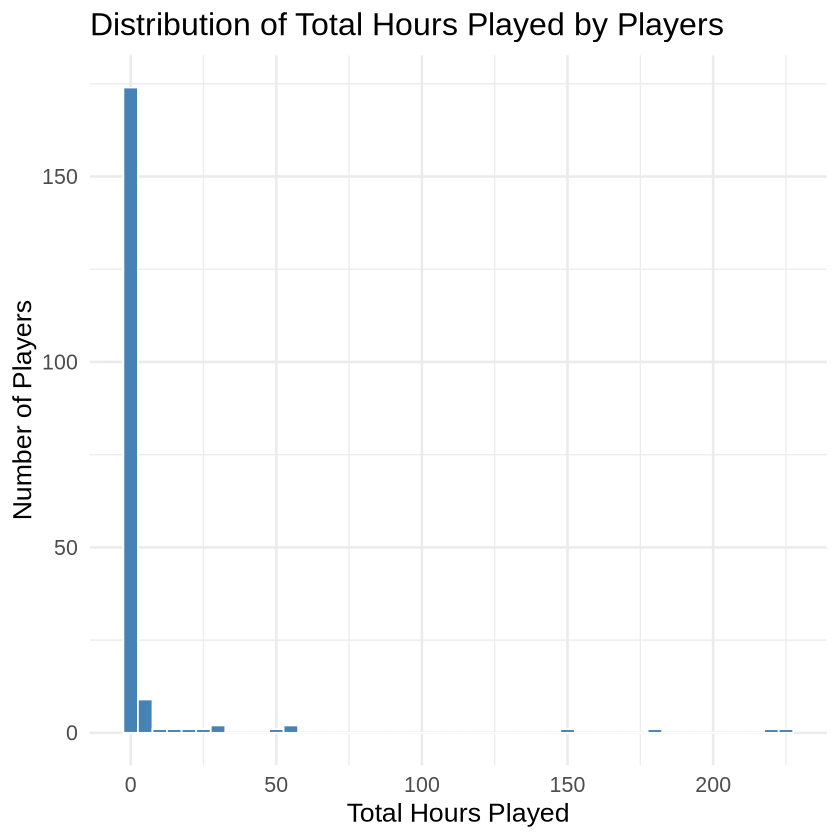

In [13]:
distribution_total_hours_played <- ggplot(player_data, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "white") +
  labs(
    title = "Distribution of Total Hours Played by Players",
    x = "Total Hours Played",
    y = "Number of Players"
  ) +
  theme_minimal(base_size = 16)
distribution_total_hours_played

Insight: this distribution graph shows that most players play for less than 10 hours, with very few playing for more than 200. This suggests that there are outliers in the data, which can be considered when wrangling data and making predictions.

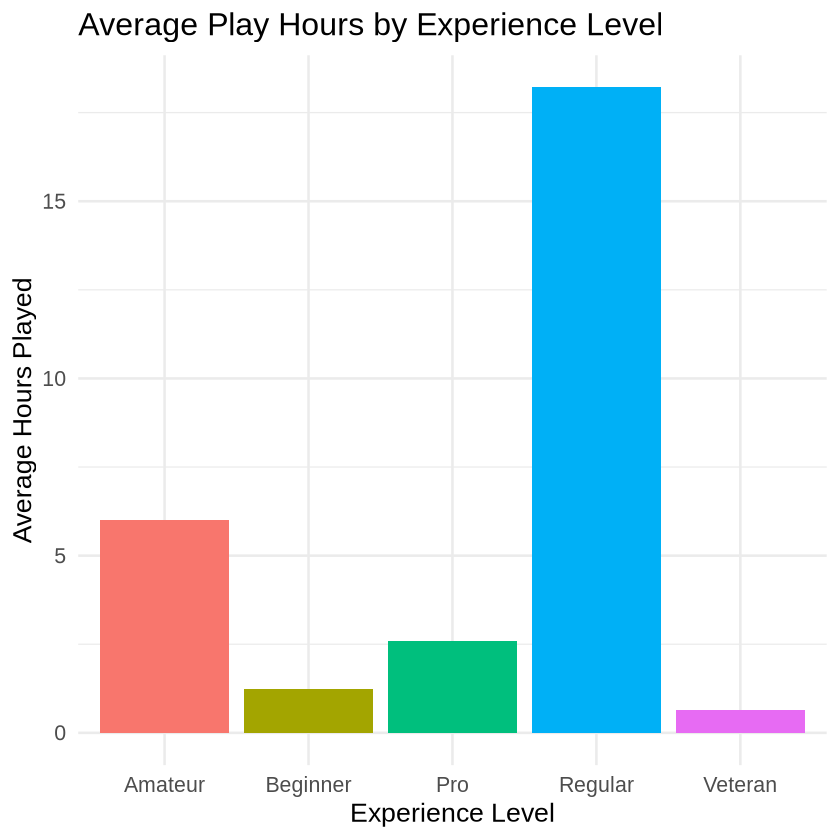

In [14]:
average_hours_played_experience <-player_data |>
  group_by(experience) |>
  summarize(mean_hours = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = experience, y = mean_hours, fill = experience)) +
  geom_col(show.legend = FALSE) +
  labs(
    title = "Average Play Hours by Experience Level",
    x = "Experience Level",
    y = "Average Hours Played"
  ) +
  theme_minimal(base_size = 16)
average_hours_played_experience 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


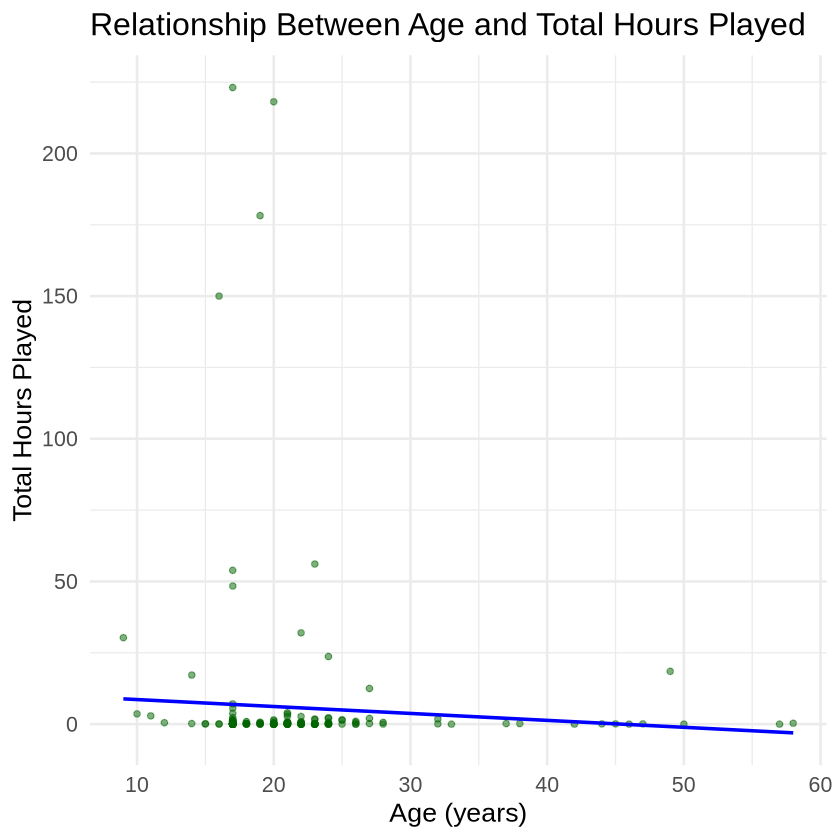

In [15]:
Total_hours_played_age<- ggplot(player_data, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.5, color = "darkgreen") +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(
    title = "Relationship Between Age and Total Hours Played",
    x = "Age (years)",
    y = "Total Hours Played"
  ) +
  theme_minimal(base_size = 16)
Total_hours_played_age


(4) Method and Plan

The method I will use to address the question is knn-regression. This method will help predict the total hours played using Age as the quantitative predictor variable, since the other variables are categorical. Thus I plan to split the data into multiple subsets and perform knn-regression on each individual subset. Since the variable experience has 5 categories, subscribe has 2 categories and gender has 7 categories, there would be 70 potential subsets of data (5 x 2 x 7). Then, k-nn regression will be performed with Age as the predictor and played_hours as the response variable, since categorical variables cannot be predictors for k-nn regression. 
This method is appropriate because it can capture nonlinear relationships between age and total playtime. Furthermore, due to the mix of categorical and quantitative data, splitting the data into subsets is most appropriate so that knn-regression can still be performed.

The only assumptions needed to apply this method is that players with similar ages within each category subset would also be expected to have similar playtime. Otherwise, no other assumptions are nessacary.

A limitation is that the method would not work as well with variable combinations that have small sample sizes, due to lack of neighbors to make reliable predictions. Furthermore, splitting data into subsets reduces the overall sample size, which further reduces the reliability of the predictions.

Before applying the model, the plan is to perform cross validation within each subset, which would help select the opitmal k value and model for each variable combination. However, this is only possible with variable combinations that have sufficient sample size. Prior to the cross validation, the data will be split 90% into training and 10% into testing. The larger split into training is to ensure that there is enough data for model fitting 